In [1]:
!nvidia-smi

Sat Mar 26 16:03:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install datasets transformers

     |████████████████████████████████| 325 kB 4.4 MB/s            
     |████████████████████████████████| 212 kB 59.5 MB/s            


In [3]:
# !wget -O train.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
# !wget -O test.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/test_en.jsonl.bz2
    
!wget -O train.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_fi_deepl.jsonl.bz2
!wget -O test.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/test_fi_deepl.jsonl.bz2

!bzip2 -dk train.jsonl.bz2
!bzip2 -dk test.jsonl.bz2

!ls -l

!head train.jsonl.bz2
!head test.jsonl.bz2

--2022-03-26 16:04:10--  https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_fi_deepl.jsonl.bz2
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_fi_deepl.jsonl.bz2 [following]
--2022-03-26 16:04:10--  https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_fi_deepl.jsonl.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22402728 (21M) [application/octet-stream]
Saving to: ‘train.jsonl.bz2’

train.jsonl.bz2     100%[===================>]  21.36M  --.-KB/s    in 0.1s    

2022-03-26 16:04:10 (159 MB/s) - ‘tr

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

output_dir = "./results-base"
#output_dir = "./drive/MyDrive/utu/kandi/results1"
checkpoint_dir = None # "./results/checkpoint-15000"

#tokenizer_name = "bert-base-uncased"
# tokenizer_name = "xlm-roberta-base"
tokenizer_name = "TurkuNLP/bert-base-finnish-cased-v1"

labels = ["label_identity_attack", "label_insult", "label_obscene", "label_severe_toxicity", "label_threat", "label_toxicity"]

device

'cuda:0'

In [5]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("WANDB_API_KEY")

os.environ['WANDB_API_KEY'] = wandb_key

In [6]:
import numpy as np
from datasets import load_dataset, Dataset

dataset = load_dataset('json', data_files={'train': 'train.jsonl', 'test': 'test.jsonl'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-d86fa19261acf129/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'id': ['ee9697785fe41ff8', '29fec512f2ee929e', '88944b29dde50648', 'c7bf1f59096102f3', '7d71ee0e8ea0794a'], 'label_identity_attack': [0, 0, 0, 0, 0], 'label_insult': [0, 0, 0, 0, 0], 'label_obscene': [0, 0, 0, 0, 0], 'label_severe_toxicity': [0, 0, 0, 0, 0], 'label_threat': [0, 0, 0, 0, 0], 'label_toxicity': [0, 0, 0, 0, 0], 'lang': ['fi-deepl', 'fi-deepl', 'fi-deepl', 'fi-deepl', 'fi-deepl'], 'text': ['"\nKiitos Xeno. - Talk - "', '2009 (UTC)\nKorjattu 03:36, 8 kesäkuu', 'Kysymys\nMitä vikaa tekemässäni korjauksessa oli?', 'Olen itse asiassa nyt samaa mieltä. (Uskomatonta, miten kieltäjät eivät pysty myöntämään virheitään!!)', 'Kisumu \n\nHuomasin, että olet osallistunut Kisumun julkaisemiseen, ja mietin, voisimmeko yhdessä päivittää Kisumun sivua, joka on tällä hetkellä kuin matkaesite, mikä ei ole kovinkaan sopivaa Itä-Afrikan johtavalle kaupungille. Jos mahdollista, voisitko auttaa minua rakentavasti parantamaan sivua, toivon saavani kokoon työryhmän, joka auttaisi minua, jotta se

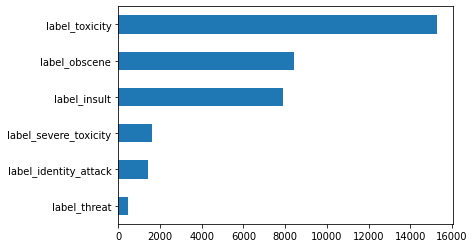

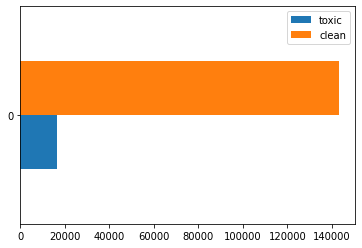

In [7]:
import pandas as pd

df_pandas = pd.DataFrame(dataset['train'])
df_pandas[labels].sum().sort_values().plot(kind="barh");

train_toxic = df_pandas[df_pandas[labels].sum(axis=1) > 0]
train_clean = df_pandas[df_pandas[labels].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

train_df = df_pandas
#train_df = pd.concat([
#  train_toxic,
#  train_clean.sample(20_000, random_state=123)
#])
# shuffle
#train_df = train_df.sample(frac=1, random_state=123)

#dataset['train'] = Dataset.from_pandas(train_df)

print(dataset['train'][:5])
print(dataset)

In [8]:
print(len(train_toxic))
print(len(train_clean))

16225
143346


In [9]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

def preprocess(items):
    return tokenizer(items["text"], truncation=True, max_length=256, padding="max_length")

ds = dataset.remove_columns(["id", "lang"])
ds = ds.map(lambda it: {'labels': torch.FloatTensor([it[label] for label in labels])})
ds = ds.remove_columns(labels)
tokenized_data = ds.map(preprocess, batched=True)
tokenized_data = tokenized_data.remove_columns(["text"])

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/796k [00:00<?, ?B/s]

  0%|          | 0/159571 [00:00<?, ?ex/s]

  0%|          | 0/63978 [00:00<?, ?ex/s]

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/64 [00:00<?, ?ba/s]

In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
#tokenized_data['train'][0]

In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback

model = None
if checkpoint_dir is not None:
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)
else:
  model = AutoModelForSequenceClassification.from_pretrained(
                                                           tokenizer_name,
                                                           num_labels=len(labels),
                                                           problem_type="multi_label_classification",
                                                           id2label={int(i): v for i, v in enumerate(labels)},
                                                           label2id={str(v): i for i, v in enumerate(labels)},
                                                          )
# model = model.to(device)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [13]:
from sklearn.utils import class_weight

class_counts = [v for v in train_df[labels].sum()]
pos_weights = np.ones_like(class_counts)

neg_counts = [len(dataset['train']) - count for count in class_counts]
print("i", "pos.", "neg.")
for i, (pos, neg) in enumerate(zip(class_counts,  neg_counts)):
    print(i, pos, neg)
    pos_weights[i] = neg / pos

class_weights = pos_weights
class_weights

i pos. neg.
0 1405 158166
1 7877 151694
2 8449 151122
3 1595 157976
4 478 159093
5 15294 144277


array([112,  19,  17,  99, 332,   9])

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, hamming_loss
from scipy.special import expit as sigmoid
from torch import nn

def compute_metrics(pred):
    y_act = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred > 0.5).astype(float)
    
    print("-------- classification report --------")
    print(classification_report(y_act, y_pred, target_names=labels))
    print("-------- roc auc -------- ")
    
    roc_auc = roc_auc_score(y_act, y_pred, labels=labels, average="macro")
    print(roc_auc)
    print("-------- hamming_loss -------- ")
    print(hamming_loss(y_act, y_pred))
    print("-------- end --------")
    
    metrics = classification_report(y_act, y_pred, target_names=labels, output_dict=True)
    metrics["avg_f1"] = metrics["weighted avg"]["f1-score"]
    metrics['roc_auc'] = roc_auc
    metrics['hamming_l0ss'] = hamming_loss(y_act, y_pred)
    
    return metrics

class_weights = torch.tensor(class_weights).to(device)

class CustomTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs['logits']
        loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir=output_dir + "-2e-16b-acc2-trunc256-4e-finbert",
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4, # TODO
    weight_decay=0.01,
    evaluation_strategy="steps",
    warmup_steps=2000,
    eval_steps=2500, # 5000
    save_steps=2500,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_avg_f1"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"].select(range(20_000)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

if checkpoint_dir is not None:
    trainer.train(checkpoint_dir)
else:
    trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


***** Running training *****
  Num examples = 159571
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 19948
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: toppev (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss,Label Identity Attack,Label Insult,Label Obscene,Label Severe Toxicity,Label Threat,Label Toxicity,Micro avg,Macro avg,Weighted avg,Samples avg,Avg F1,Roc Auc,Hamming L0ss
2500,0.548900,0.500620,"{'precision': 0.18988648090815274, 'recall': 0.8288288288288288, 'f1-score': 0.3089840470193115, 'support': 222}","{'precision': 0.23549644576931897, 'recall': 0.9875, 'f1-score': 0.3802999444547306, 'support': 1040}","{'precision': 0.29800054779512464, 'recall': 0.9527145359019265, 'f1-score': 0.4539954099728771, 'support': 1142}","{'precision': 0.08588957055214724, 'recall': 0.9491525423728814, 'f1-score': 0.15752461322081576, 'support': 118}","{'precision': 0.10704960835509138, 'recall': 0.6949152542372882, 'f1-score': 0.18552036199095023, 'support': 59}","{'precision': 0.3142712550607287, 'recall': 0.9794952681388013, 'f1-score': 0.47586206896551714, 'support': 1902}","{'precision': 0.26000241021932996, 'recall': 0.9625250948025875, 'f1-score': 0.4094122112054651, 'support': 4483}","{'precision': 0.20509898474009394, 'recall': 0.898767738246621, 'f1-score': 0.3270310742707004, 'support': 4483}","{'precision': 0.2769535024062779, 'recall': 0.9625250948025875, 'f1-score': 0.42765835818651987, 'support': 4483}","{'precision': 0.05979333333333333, 'recall': 0.09350416666666667, 'f1-score': 0.06975123737373738, 'support': 4483}",0.427658,0.894954,0.103742
5000,0.474200,0.434203,"{'precision': 0.21084953940634596, 'recall': 0.9279279279279279, 'f1-score': 0.34361968306922436, 'support': 222}","{'precision': 0.3295492487479132, 'recall': 0.9490384615384615, 'f1-score': 0.48921933085501856, 'support': 1040}","{'precision': 0.3338490099009901, 'recall': 0.9448336252189142, 'f1-score': 0.4933699131229996, 'support': 1142}","{'precision': 0.10186915887850467, 'recall': 0.923728813559322, 'f1-score': 0.18350168350168353, 'support': 118}","{'precision': 0.1618705035971223, 'recall': 0.7627118644067796, 'f1-score': 0.26706231454005935, 'support': 59}","{'precision': 0.4229147141518276, 'recall': 0.9490010515247108, 'f1-score': 0.5850891410048622, 'support': 1902}","{'precision': 0.3300312012480499, 'recall': 0.9437876422038813, 'f1-score': 0.4890481419407039, 'support': 4483}","{'precision': 0.2601503624471173, 'recall': 0.9095402906960192, 'f1-score': 0.393643677682308, 'support': 4483}","{'precision': 0.35617891869945106, 'recall': 0.9437876422038813, 'f1-score': 0.5127703626855594, 'support': 4483}","{'precision': 0.05879749999999999, 'recall': 0.09058916666666667, 'f1-score': 0.06824255411255412, 'support': 4483}",0.512770,0.916839,0.073675
7500,0.385700,0.462733,"{'precision': 0.25839793281653745, 'recall': 0.9009009009009009, 'f1-score': 0.4016064257028112, 'support': 222}","{'precision': 0.3716608594657375, 'recall': 0.9230769230769231, 'f1-score': 0.5299475572729782, 'support': 1040}","{'precision': 0.4178628389154705, 'recall': 0.9176882661996497, 'f1-score': 0.5742465753424657, 'support': 1142}","{'precision': 0.13205282112845138, 'recall': 0.9322033898305084, 'f1-score': 0.231335436382755, 'support': 118}","{'precision': 0.2606060606060606, 'recall': 0.7288135593220338, 'f1-score': 0.38392857142857145, 'support': 59}","{'precision': 0.42642219087917255, 'recall': 0.953732912723449, 'f1-score': 0.5893437296946069, 'support': 1902}","{'precision': 0.3755509579922641, 'recall': 0.9312960071380771, 'f1-score': 0.5352564102564104, 'support': 4483}","{'precision': 0.311167117301905, 'recall': 0.892735992008911, 'f1-score': 0.4517347159706981, 'support': 4483}","{'precision': 0.3932866371831824, 'recall': 0.9312960071380771, 'f1-score': 0.5502950738785658, 'support': 4483}","{'precision': 0.06423916666666667, 'recall': 0.08948666666666666, 'f1-score': 0.07140886002886002, 'support': 4483}",0.550295,0.915589,0.060417
10000,0.317300,0.513495,"{'precision': 0.2992248062015504, 'recall': 0.8693693693693694, 'f1-score': 0.44521337946943484, 'support': 222}","{'precision': 0.3786407766990291, 'recall': 0.9375, '

***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/op

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.19      0.83      0.31       222
         label_insult       0.24      0.99      0.38      1040
        label_obscene       0.30      0.95      0.45      1142
label_severe_toxicity       0.09      0.95      0.16       118
         label_threat       0.11      0.69      0.19        59
       label_toxicity       0.31      0.98      0.48      1902

            micro avg       0.26      0.96      0.41      4483
            macro avg       0.21      0.90      0.33      4483
         weighted avg       0.28      0.96      0.43      4483
          samples avg       0.06      0.09      0.07      4483

-------- roc auc -------- 
0.8949538931662793
-------- hamming_loss -------- 
0.10374166666666666
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-2500
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-2500/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-2500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-2500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.21      0.93      0.34       222
         label_insult       0.33      0.95      0.49      1040
        label_obscene       0.33      0.94      0.49      1142
label_severe_toxicity       0.10      0.92      0.18       118
         label_threat       0.16      0.76      0.27        59
       label_toxicity       0.42      0.95      0.59      1902

            micro avg       0.33      0.94      0.49      4483
            macro avg       0.26      0.91      0.39      4483
         weighted avg       0.36      0.94      0.51      4483
          samples avg       0.06      0.09      0.07      4483

-------- roc auc -------- 
0.9168392314640351
-------- hamming_loss -------- 
0.073675
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-5000
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-5000/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-5000/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-5000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.26      0.90      0.40       222
         label_insult       0.37      0.92      0.53      1040
        label_obscene       0.42      0.92      0.57      1142
label_severe_toxicity       0.13      0.93      0.23       118
         label_threat       0.26      0.73      0.38        59
       label_toxicity       0.43      0.95      0.59      1902

            micro avg       0.38      0.93      0.54      4483
            macro avg       0.31      0.89      0.45      4483
         weighted avg       0.39      0.93      0.55      4483
          samples avg       0.06      0.09      0.07      4483

-------- roc auc -------- 
0.9155889742315608
-------- hamming_loss -------- 
0.06041666666666667
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-7500
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-7500/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-7500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-7500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.30      0.87      0.45       222
         label_insult       0.38      0.94      0.54      1040
        label_obscene       0.39      0.93      0.55      1142
label_severe_toxicity       0.13      0.92      0.23       118
         label_threat       0.30      0.75      0.43        59
       label_toxicity       0.47      0.94      0.62      1902

            micro avg       0.39      0.93      0.55      4483
            macro avg       0.33      0.89      0.47      4483
         weighted avg       0.41      0.93      0.56      4483
          samples avg       0.06      0.09      0.07      4483

-------- roc auc -------- 
0.9156242660870205
-------- hamming_loss -------- 
0.05723333333333333
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-10000
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-10000/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-10000/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-10000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: Undefine

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.34      0.91      0.49       222
         label_insult       0.41      0.91      0.56      1040
        label_obscene       0.43      0.91      0.58      1142
label_severe_toxicity       0.19      0.85      0.31       118
         label_threat       0.34      0.71      0.46        59
       label_toxicity       0.43      0.95      0.59      1902

            micro avg       0.41      0.92      0.56      4483
            macro avg       0.36      0.87      0.50      4483
         weighted avg       0.41      0.92      0.57      4483
          samples avg       0.07      0.09      0.07      4483

-------- roc auc -------- 
0.9091276707849442
-------- hamming_loss -------- 
0.053366666666666666
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-12500
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-12500/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-12500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-12500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-12500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: Undefine

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.36      0.86      0.50       222
         label_insult       0.46      0.88      0.60      1040
        label_obscene       0.46      0.89      0.61      1142
label_severe_toxicity       0.18      0.86      0.30       118
         label_threat       0.27      0.78      0.40        59
       label_toxicity       0.48      0.93      0.63      1902

            micro avg       0.44      0.90      0.59      4483
            macro avg       0.37      0.87      0.51      4483
         weighted avg       0.45      0.90      0.60      4483
          samples avg       0.07      0.09      0.07      4483

-------- roc auc -------- 
0.9105588197927795
-------- hamming_loss -------- 
0.04635
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-15000
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-15000/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-15000/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-15000/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-15000/special_tokens_map.json
Deleting older checkpoint [results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-2500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.43      0.79      0.56       222
         label_insult       0.49      0.85      0.62      1040
        label_obscene       0.48      0.88      0.62      1142
label_severe_toxicity       0.20      0.79      0.31       118
         label_threat       0.41      0.69      0.51        59
       label_toxicity       0.48      0.92      0.63      1902

            micro avg       0.46      0.88      0.61      4483
            macro avg       0.41      0.82      0.54      4483
         weighted avg       0.47      0.88      0.61      4483
          samples avg       0.07      0.08      0.07      4483

-------- roc auc -------- 
0.8897265119754255
-------- hamming_loss -------- 
0.0425
-------- end --------


Saving model checkpoint to ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-17500
Configuration saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-17500/config.json
Model weights saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-17500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-17500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-17500/special_tokens_map.json
Deleting older checkpoint [results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-5000] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results-base-2e-16b-acc2-trunc256-4e-finbert/checkpoint-17500 (score: 0.6128807504613596).


In [15]:
# Test
# preds = trainer.predict(tokenized_data['test'])
# compute_metrics(preds)

In [16]:
#!zip -r ./checkpoint.zip ./results/checkpoint-12000